In [1]:
import os
from pathlib import Path

import numpy as np
import dotenv
import tensorflow as tf
import h5py
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
import seaborn as sns

from src.models.fetch_data_from_hdf5 import get_tf_data
from src.models.train_model_2d import CustomLoss

In [2]:
project_dir = Path("../")
dotenv_path = project_dir / ".env"
dotenv.load_dotenv(str(dotenv_path))

path_clinical_info = Path(os.environ["CLINIC_INFO_PATH"])

model = "model_gtvl_only"
model_path = project_dir / f"models/clean_model/{model}"
path_volume_csv = project_dir / f"data/plc_volume/{model}.csv"

bs = 4
image_size = (256, 256)

In [3]:
clinical_df = pd.read_csv(path_clinical_info).set_index("patient_id")

volume_pred_df = pd.read_csv(path_volume_csv)
volume_pred_df["patient_id"] = volume_pred_df["patient_id"].astype(int)
volume_pred_df = volume_pred_df.set_index("patient_id")

df = pd.concat([clinical_df, volume_pred_df], axis=1)
df = df.dropna(axis=0)


In [4]:
df["plc_volume_cubed"] = df["plc_volume"].map(lambda x: np.cbrt(x))

<AxesSubplot:xlabel='plc_status', ylabel='plc_volume_cubed'>

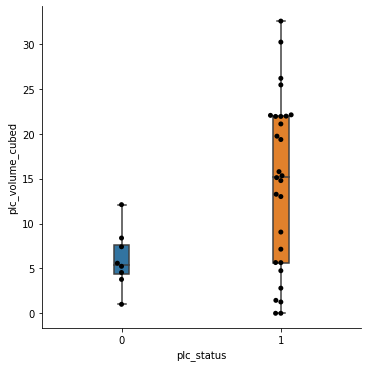

In [5]:
sns.catplot(x='plc_status',y='plc_volume_cubed', height=5,kind='box', width=0.1, aspect=1, data=df)
sns.swarmplot(x='plc_status',y='plc_volume_cubed', data=df, color="black")

In [6]:
file_test = h5py.File(
    "/home/val/python_wkspce/plc_seg/data/processed/2d_pet_normalized/test.hdf5",
    "r")

data_test = get_tf_data(
    file_test,
    clinical_df,
    output_shape=(256, 256),
    random_slice=False,
    label_to_center="GTV L",
    return_complete_gtvl=True,
    return_patient=True,
    return_plc_status=True,
).batch(4)


In [7]:
model = tf.keras.models.load_model(model_path, compile=False)
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)
model.compile(
    loss=CustomLoss(),
    optimizer=optimizer,
    run_eagerly=False,
)


In [8]:
for x, y_true, plc_status, patient_id in data_test.as_numpy_iterator():
    y_pred = model(x).numpy()
    print(f"Dynamic range of ct [{np.min(x[...,0])}, {np.max(x[...,0])}]\n"
    f"Dynamic range of pt [{np.min(x[...,1])}, {np.max(x[...,1])}]\n"
    f"Dynamic range of third channel [{np.min(x[...,2])}, {np.max(x[...,2])}]"
    )

Dynamic range of ct [-1.0, 1.0]
Dynamic range of pt [-0.5148023366928101, 43.357635498046875]
Dynamic range of third channel [0.0, 0.0]
Dynamic range of ct [-0.7859929800033569, 1.0]
Dynamic range of pt [-0.4842640161514282, 24.766559600830078]
Dynamic range of third channel [0.0, 0.0]
Dynamic range of ct [-1.0, 1.0]
Dynamic range of pt [-0.5240480303764343, 17.09098243713379]
Dynamic range of third channel [0.0, 0.0]
Dynamic range of ct [-0.9497581124305725, 1.0]
Dynamic range of pt [-0.6041936278343201, 22.008337020874023]
Dynamic range of third channel [0.0, 0.0]
Dynamic range of ct [-0.5868774652481079, 1.0]
Dynamic range of pt [-0.5240480303764343, 11.75966739654541]
Dynamic range of third channel [0.0, 0.0]
Dynamic range of ct [-1.0, 1.0]
Dynamic range of pt [-0.5197181105613708, 15.472431182861328]
Dynamic range of third channel [0.0, 0.0]
Dynamic range of ct [-1.0, 1.0]
Dynamic range of pt [-0.4760938882827759, 30.70351219177246]
Dynamic range of third channel [0.0, 0.0]
Dynami

In [ ]:

for x, y_true, plc_status, patient_id in data_test.as_numpy_iterator():
    for i in range(x.shape[0]):
        fig, axs = plt.subplots(1, 3, figsize=(16,8))
        fig.subplots_adjust(left=0.05, bottom=0.06, right=0.95, top=0.94, wspace=0.4)
        
        im1 = axs[0].axis('off')
        im1 = axs[0].imshow(x[i,:,:,0],cmap='gray')
        im1 = axs[0].imshow(y_true[i, :,:,4], cmap='jet', alpha=0.5)
        axs[0].set_title("VOI L")

        im2 = axs[1].axis('off')
        im2 = axs[1].imshow(x[i,:,:,0],cmap='gray')
        im2 = axs[1].imshow(x[i, :,:,1], cmap='hot', alpha=0.5, norm=Normalize(vmin=0.0, vmax=2.5, clip=True))
        axs[1].margins(2,2)
        cax2 = fig.add_axes([axs[1].get_position().x1+0.01,axs[1].get_position().y0,0.02,axs[1].get_position().height])
        plt.colorbar(im2, cax=cax2) # Similar to fig.colorbar(im, cax = cax)
        axs[1].set_title("PET/CT")

        im3 = axs[2].axis('off')
        im3 = axs[2].imshow(x[i,:,:,0],cmap='gray')
        im3 = axs[2].imshow(y_pred[i, :,:,1], cmap='jet', alpha=0.5, norm=Normalize(vmin=0.0, vmax=0.5, clip=True))
        cax3 = fig.add_axes([axs[2].get_position().x1+0.01,axs[2].get_position().y0,0.02,axs[2].get_position().height])
        plt.colorbar(im3, cax=cax3) # Similar to fig.colorbar(im, cax = cax)
        axs[2].set_title("Prediction")
        
        
        
        
        p_id  = patient_id[i].decode('utf-8')
        volume = volume_pred_df[volume_pred_df["patient_name"]==p_id]["plc_volume"].values[0]
        fig.suptitle(f"{patient_id[i].decode('utf-8')}\nPLC status: {int(plc_status[i,0])}"
        f"\nPredicted volume {volume} [mm$^3$]", fontsize=20)
        path_to_save = f"/home/val/python_wkspce/plc_seg/reports/figures/{p_id}.png"
        fig.savefig(path_to_save, transparent=False, facecolor="white")
        plt.close(fig=fig)




In [ ]:

# file_train.close()
file_test.close()

In [ ]:
file_train = h5py.File(
    "/home/val/python_wkspce/plc_seg/data/processed/2d_pet_normalized/train.hdf5",
    "r")
patient_list = list(file_train.keys())
patient_list = [p for p in patient_list if p not in ["PatientLC_63"]]

data_train = get_tf_data(
    file_train,
    clinical_df,
    output_shape=(256, 256),
    random_slice=False,
    label_to_center="GTV L",
    return_complete_gtvl=True,
    return_patient=True,
    return_plc_status=True,
    patient_list=patient_list,
).batch(4)


In [ ]:
for x, y_true, plc_status, patient_id in data_train.as_numpy_iterator():
    y_pred = model(x).numpy()
    for i in range(x.shape[0]):
        fig, axs = plt.subplots(1, 3, figsize=(16,8))
        fig.subplots_adjust(left=0.05, bottom=0.06, right=0.95, top=0.94, wspace=0.4)
        
        im1 = axs[0].axis('off')
        im1 = axs[0].imshow(x[i,:,:,0],cmap='gray')
        im1 = axs[0].imshow(y_true[i, :,:,4], cmap='jet', alpha=0.5)
        axs[0].set_title("VOI L")

        im2 = axs[1].axis('off')
        im2 = axs[1].imshow(x[i,:,:,0],cmap='gray')
        im2 = axs[1].imshow(x[i, :,:,1], cmap='hot', alpha=0.5, norm=Normalize(vmin=0.0, vmax=2.5, clip=True))
        axs[1].margins(2,2)
        cax2 = fig.add_axes([axs[1].get_position().x1+0.01,axs[1].get_position().y0,0.02,axs[1].get_position().height])
        plt.colorbar(im2, cax=cax2) # Similar to fig.colorbar(im, cax = cax)
        axs[1].set_title("PET/CT")

        im3 = axs[2].axis('off')
        im3 = axs[2].imshow(x[i,:,:,0],cmap='gray')
        im3 = axs[2].imshow(y_pred[i, :,:,1], cmap='jet', alpha=0.5, norm=Normalize(vmin=0.0, vmax=0.5, clip=True))
        cax3 = fig.add_axes([axs[2].get_position().x1+0.01,axs[2].get_position().y0,0.02,axs[2].get_position().height])
        plt.colorbar(im3, cax=cax3) # Similar to fig.colorbar(im, cax = cax)
        axs[2].set_title("Prediction")
        
        
        
        
        p_id  = patient_id[i].decode('utf-8')
        fig.suptitle(f"{patient_id[i].decode('utf-8')}\nPLC status: {int(plc_status[i,0])}"
        f"\nTRAIN", fontsize=20)
        path_to_save = f"/home/val/python_wkspce/plc_seg/reports/figures_train/{p_id}.png"
        fig.savefig(path_to_save, transparent=False, facecolor="white")
        plt.close(fig=fig)

In [ ]:
clinical_df.iloc[np.isnan(clinical_df["sick_lung_axis"].values),:]

In [ ]:
file_train.keys()